# Complete Guide to Ridge and Lasso Regression
## L1 and L2 Regularization

## Learning Objectives
By the end of this notebook, you will understand:
1. Why we need regularization
2. Ridge Regression (L2 regularization)
3. Lasso Regression (L1 regularization)
4. Elastic Net (combination of L1 and L2)
5. How to select regularization parameters
6. Feature selection with Lasso
7. Real-world applications and best practices

---

## 1. The Problem: Overfitting

### What Happens Without Regularization?

**Linear Regression** minimizes:
$$L(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \mathbf{w}^T\mathbf{x}_i)^2$$

### Problems:
1. **Overfitting**: Model fits noise in training data
2. **Large coefficients**: Sensitive to small changes
3. **Poor generalization**: Bad performance on new data
4. **Multicollinearity**: Unstable when features correlated

### Solution: Regularization

Add a penalty term to discourage large weights:
$$L(\mathbf{w}) = \text{MSE} + \text{Penalty}$$

This encourages:
- ✅ Simpler models
- ✅ Smaller coefficients
- ✅ Better generalization
- ✅ More stable predictions

=== OVERFITTING DEMONSTRATION ===

Data: 50 samples, 100 features
More features than samples: True

Linear Regression (No Regularization):
  Training R²: 1.0000
  Test R²: 0.1543
  Coefficient range: [-17.03, 27.22]
  Max |coefficient|: 27.22


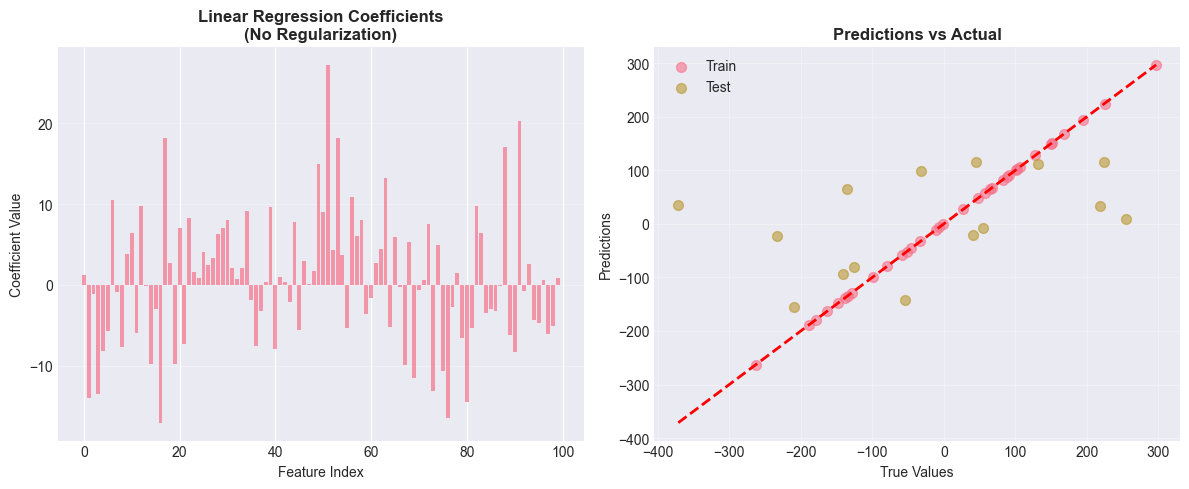


⚠️ PROBLEMS:
  • Perfect training fit but poor test performance
  • Very large coefficient values
  • Model is overfitting!

💡 SOLUTION: Regularization!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import make_regression, load_diabetes
import pandas as pd

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

# Demonstrate overfitting problem
def demonstrate_overfitting():
    # Generate data with many features, few samples
    n_samples = 50
    n_features = 100
    X, y = make_regression(n_samples=n_samples, n_features=n_features, 
                          n_informative=10, noise=10, random_state=42)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Train regular linear regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    print("=== OVERFITTING DEMONSTRATION ===")
    print(f"\nData: {n_samples} samples, {n_features} features")
    print(f"More features than samples: {n_features > n_samples}")
    
    print(f"\nLinear Regression (No Regularization):")
    print(f"  Training R²: {lr.score(X_train, y_train):.4f}")
    print(f"  Test R²: {lr.score(X_test, y_test):.4f}")
    print(f"  Coefficient range: [{np.min(lr.coef_):.2f}, {np.max(lr.coef_):.2f}]")
    print(f"  Max |coefficient|: {np.max(np.abs(lr.coef_)):.2f}")
    
    # Visualize coefficients
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(lr.coef_)), lr.coef_, alpha=0.7)
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.title('Linear Regression Coefficients\n(No Regularization)', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.subplot(1, 2, 2)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    plt.scatter(y_train, y_train_pred, alpha=0.6, label='Train', s=50)
    plt.scatter(y_test, y_test_pred, alpha=0.6, label='Test', s=50)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Predictions vs Actual', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n⚠️ PROBLEMS:")
    print("  • Perfect training fit but poor test performance")
    print("  • Very large coefficient values")
    print("  • Model is overfitting!")
    print("\n💡 SOLUTION: Regularization!")

demonstrate_overfitting()

---
## 2. Ridge Regression (L2 Regularization)

### Mathematical Formulation

**Ridge adds L2 penalty** (sum of squared coefficients):

$$L_{Ridge}(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \mathbf{w}^T\mathbf{x}_i)^2 + \alpha\sum_{j=1}^{d}w_j^2$$

Or in vector form:
$$L_{Ridge}(\mathbf{w}) = ||\mathbf{Xw} - \mathbf{y}||^2 + \alpha||\mathbf{w}||^2$$

Where:
- $\alpha \geq 0$ : regularization strength (hyperparameter)
- $||\mathbf{w}||^2 = w_1^2 + w_2^2 + ... + w_d^2$ : L2 norm squared

### Closed-Form Solution

$$\mathbf{w}^* = (\mathbf{X}^T\mathbf{X} + \alpha\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

### Key Properties:
1. **Shrinks coefficients** toward zero (but never exactly zero)
2. **Handles multicollinearity** by adding $\alpha\mathbf{I}$ to $\mathbf{X}^T\mathbf{X}$
3. **Always has solution** (even when $\mathbf{X}^T\mathbf{X}$ is singular)
4. **Smooth shrinkage**: All coefficients shrink proportionally

### When to Use Ridge:
- ✅ Many features
- ✅ Correlated features
- ✅ Want to keep all features
- ✅ Reduce overfitting

In [2]:
# Ridge Regression from scratch
class RidgeRegressionScratch:
    """
    Ridge Regression implementation from scratch
    """
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        """
        Fit Ridge regression using closed-form solution
        w = (X^T X + αI)^(-1) X^T y
        """
        # Add bias term
        X_with_bias = np.c_[np.ones(X.shape[0]), X]
        
        # Create regularization matrix (don't penalize bias)
        reg_matrix = self.alpha * np.eye(X_with_bias.shape[1])
        reg_matrix[0, 0] = 0  # Don't regularize bias
        
        # Closed-form solution
        w = np.linalg.solve(
            X_with_bias.T @ X_with_bias + reg_matrix,
            X_with_bias.T @ y
        )
        
        self.bias = w[0]
        self.weights = w[1:]
        
        return self
    
    def predict(self, X):
        return X @ self.weights + self.bias
    
    def score(self, X, y):
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        return 1 - (ss_res / ss_tot)

# Test Ridge implementation
print("=== RIDGE REGRESSION ===")

# Generate data
X, y = make_regression(n_samples=100, n_features=50, 
                       n_informative=10, noise=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Compare different alpha values
alphas = [0, 0.1, 1.0, 10.0, 100.0]
results = []

for alpha in alphas:
    # Our implementation
    ridge = RidgeRegressionScratch(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    train_score = ridge.score(X_train, y_train)
    test_score = ridge.score(X_test, y_test)
    max_coef = np.max(np.abs(ridge.weights))
    
    results.append({
        'Alpha': alpha,
        'Train R²': train_score,
        'Test R²': test_score,
        'Max |coef|': max_coef
    })

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

print("\nObservations:")
print("• α=0: No regularization (overfits)")
print("• α increases: Coefficients shrink, test performance improves")
print("• α too large: Underfits (both scores decrease)")
print("• Sweet spot: α=1.0 or α=10.0 for this data")

=== RIDGE REGRESSION ===

 Alpha  Train R²  Test R²  Max |coef|
   0.0  0.998259 0.987969   85.511067
   0.1  0.998252 0.988095   85.172385
   1.0  0.997695 0.987405   82.450580
  10.0  0.975855 0.950762   67.713175
 100.0  0.702540 0.620405   31.536131

Observations:
• α=0: No regularization (overfits)
• α increases: Coefficients shrink, test performance improves
• α too large: Underfits (both scores decrease)
• Sweet spot: α=1.0 or α=10.0 for this data


### Visualizing Ridge Effect

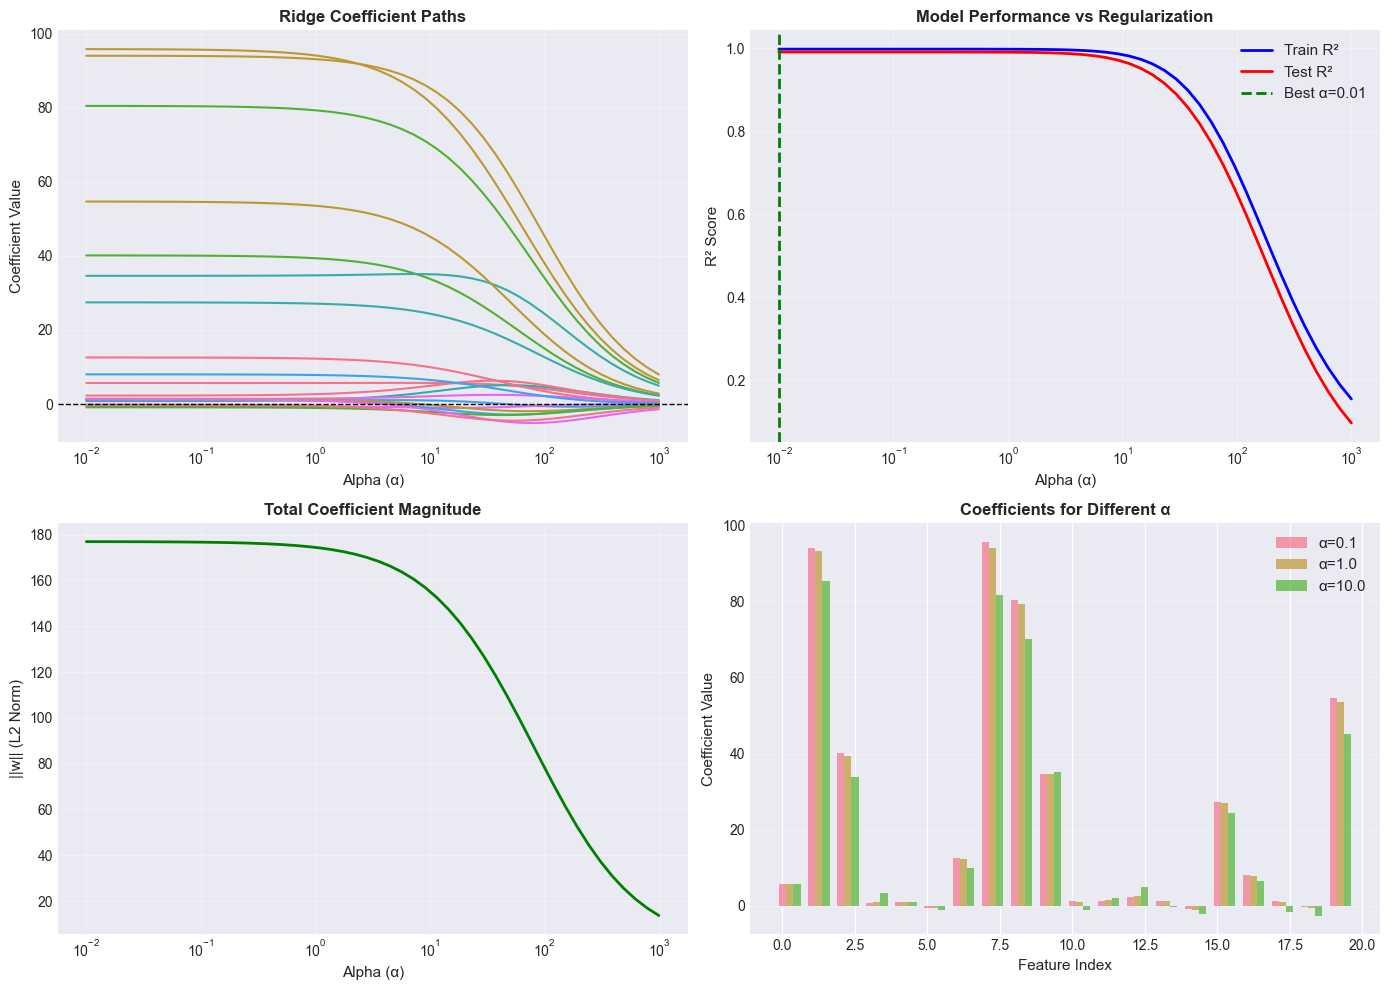

=== RIDGE SHRINKAGE PATTERNS ===

Best alpha: 0.01
Best test R²: 0.9909

Key insights:
• All coefficients shrink smoothly as α increases
• No coefficient goes exactly to zero
• Test performance peaks at optimal α
• Too much regularization hurts performance


In [3]:
# Visualize how Ridge shrinks coefficients
def visualize_ridge_shrinkage():
    # Generate data
    X, y = make_regression(n_samples=100, n_features=20, 
                          n_informative=10, noise=10, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Try many alpha values
    alphas = np.logspace(-2, 3, 50)
    coefs = []
    train_scores = []
    test_scores = []
    
    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        coefs.append(ridge.coef_)
        train_scores.append(ridge.score(X_train, y_train))
        test_scores.append(ridge.score(X_test, y_test))
    
    coefs = np.array(coefs)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Coefficient paths
    axes[0, 0].plot(alphas, coefs)
    axes[0, 0].set_xscale('log')
    axes[0, 0].set_xlabel('Alpha (α)', fontsize=11)
    axes[0, 0].set_ylabel('Coefficient Value', fontsize=11)
    axes[0, 0].set_title('Ridge Coefficient Paths', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    # Performance vs alpha
    axes[0, 1].plot(alphas, train_scores, 'b-', linewidth=2, label='Train R²')
    axes[0, 1].plot(alphas, test_scores, 'r-', linewidth=2, label='Test R²')
    axes[0, 1].set_xscale('log')
    axes[0, 1].set_xlabel('Alpha (α)', fontsize=11)
    axes[0, 1].set_ylabel('R² Score', fontsize=11)
    axes[0, 1].set_title('Model Performance vs Regularization', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Best alpha marker
    best_idx = np.argmax(test_scores)
    best_alpha = alphas[best_idx]
    axes[0, 1].axvline(x=best_alpha, color='green', linestyle='--', 
                       linewidth=2, label=f'Best α={best_alpha:.2f}')
    axes[0, 1].legend(fontsize=11)
    
    # Coefficient magnitude vs alpha
    coef_norms = np.linalg.norm(coefs, axis=1)
    axes[1, 0].plot(alphas, coef_norms, 'g-', linewidth=2)
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_xlabel('Alpha (α)', fontsize=11)
    axes[1, 0].set_ylabel('||w|| (L2 Norm)', fontsize=11)
    axes[1, 0].set_title('Total Coefficient Magnitude', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Compare specific alphas
    alphas_compare = [0.1, 1.0, 10.0]
    x_pos = np.arange(20)
    width = 0.25
    
    for i, alpha in enumerate(alphas_compare):
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        axes[1, 1].bar(x_pos + i*width, ridge.coef_, width, 
                      label=f'α={alpha}', alpha=0.7)
    
    axes[1, 1].set_xlabel('Feature Index', fontsize=11)
    axes[1, 1].set_ylabel('Coefficient Value', fontsize=11)
    axes[1, 1].set_title('Coefficients for Different α', fontsize=12, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("=== RIDGE SHRINKAGE PATTERNS ===")
    print(f"\nBest alpha: {best_alpha:.2f}")
    print(f"Best test R²: {test_scores[best_idx]:.4f}")
    print("\nKey insights:")
    print("• All coefficients shrink smoothly as α increases")
    print("• No coefficient goes exactly to zero")
    print("• Test performance peaks at optimal α")
    print("• Too much regularization hurts performance")

visualize_ridge_shrinkage()

---
## 3. Lasso Regression (L1 Regularization)

### Mathematical Formulation

**Lasso adds L1 penalty** (sum of absolute values):

$$L_{Lasso}(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \mathbf{w}^T\mathbf{x}_i)^2 + \alpha\sum_{j=1}^{d}|w_j|$$

Or in vector form:
$$L_{Lasso}(\mathbf{w}) = ||\mathbf{Xw} - \mathbf{y}||^2 + \alpha||\mathbf{w}||_1$$

Where:
- $\alpha \geq 0$ : regularization strength
- $||\mathbf{w}||_1 = |w_1| + |w_2| + ... + |w_d|$ : L1 norm

### Key Properties:
1. **Sparse solutions**: Can force coefficients exactly to zero!
2. **Feature selection**: Automatically selects important features
3. **No closed-form**: Must use iterative optimization
4. **Sharp shrinkage**: Some features eliminated completely

### Why No Closed Form?
The absolute value function is not differentiable at zero, so we use:
- Coordinate descent
- Subgradient methods
- LARS (Least Angle Regression)

### When to Use Lasso:
- ✅ Feature selection needed
- ✅ Sparse models desired
- ✅ Many irrelevant features
- ✅ Interpretability important

=== LASSO REGRESSION ===

Alpha |  Train R² |  Test R²  | Non-zero coefs
--------------------------------------------------
  0.1 |    0.9989 |    0.9916 |             28
  1.0 |    0.9984 |    0.9930 |             19
 10.0 |    0.9790 |    0.9733 |              8
 50.0 |    0.6341 |    0.6217 |              6
100.0 |    0.1540 |    0.1411 |              1

Observation:
• As α increases, more coefficients become exactly zero
• Lasso performs automatic feature selection!
• Balance between sparsity and performance


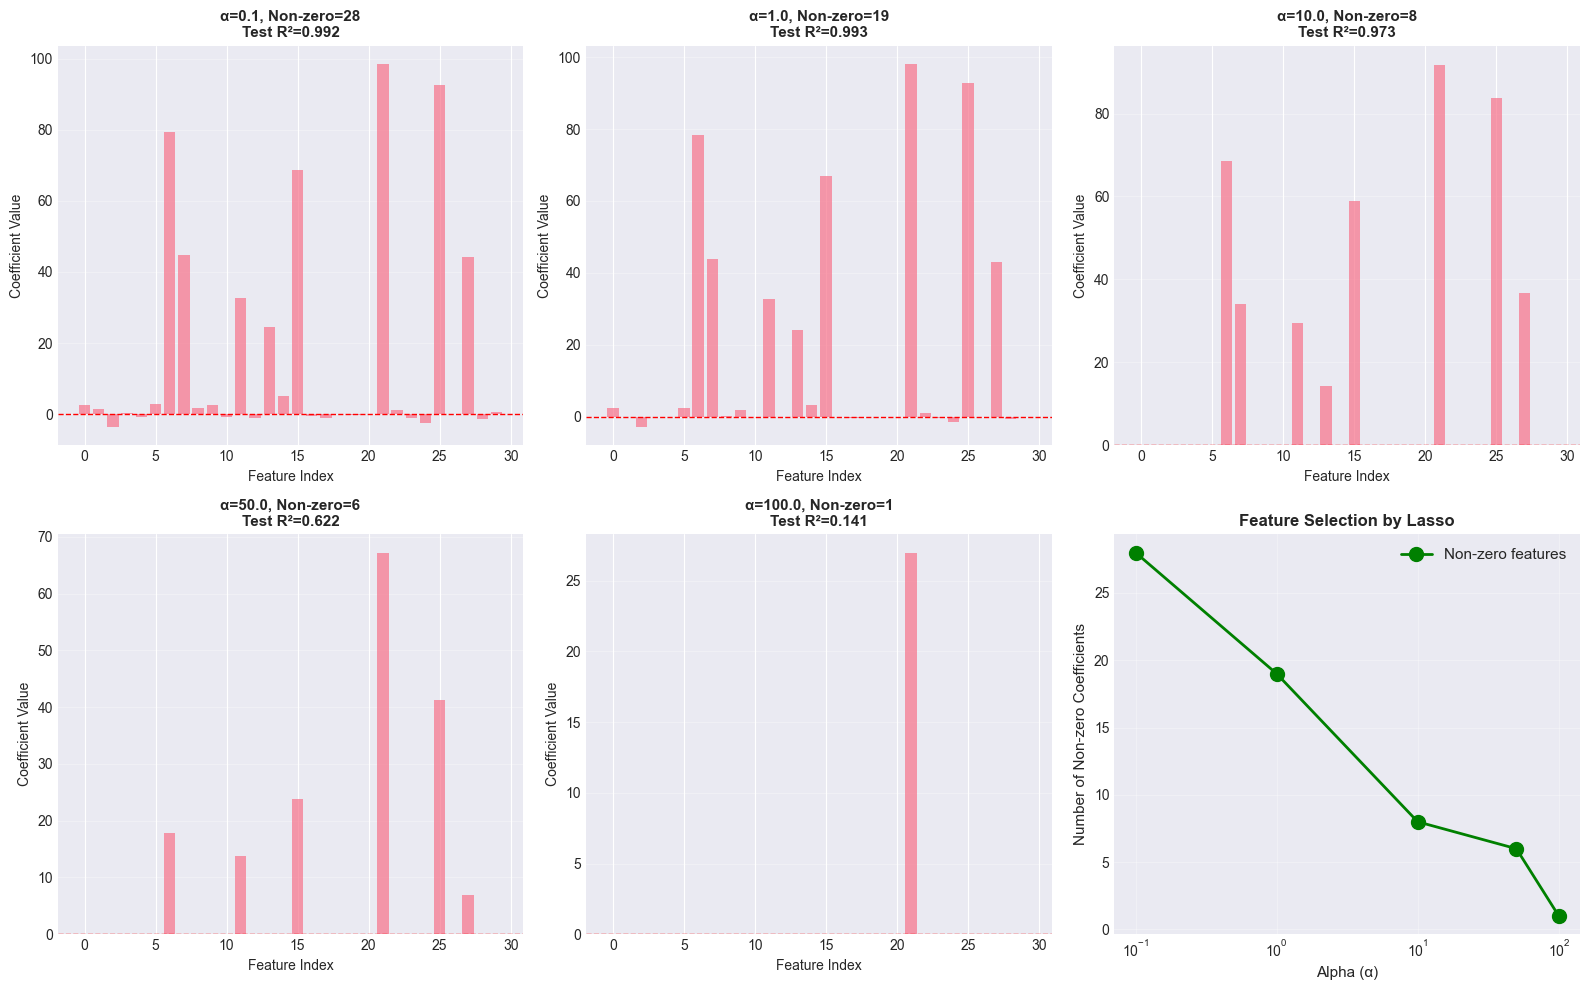

In [4]:
# Demonstrate Lasso feature selection
print("=== LASSO REGRESSION ===")

# Generate data with some irrelevant features
X, y = make_regression(n_samples=100, n_features=30, 
                       n_informative=10, noise=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Compare different alpha values
alphas = [0.1, 1.0, 10.0, 50.0, 100.0]
results = []

print("\nAlpha |  Train R² |  Test R²  | Non-zero coefs")
print("-" * 50)

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    train_score = lasso.score(X_train, y_train)
    test_score = lasso.score(X_test, y_test)
    n_nonzero = np.sum(np.abs(lasso.coef_) > 1e-5)
    
    print(f"{alpha:5.1f} | {train_score:9.4f} | {test_score:9.4f} | {n_nonzero:14d}")
    
    results.append({
        'alpha': alpha,
        'coef': lasso.coef_.copy(),
        'train_score': train_score,
        'test_score': test_score,
        'n_nonzero': n_nonzero
    })

print("\nObservation:")
print("• As α increases, more coefficients become exactly zero")
print("• Lasso performs automatic feature selection!")
print("• Balance between sparsity and performance")

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for ax, result in zip(axes[:-1], results):
    ax.bar(range(len(result['coef'])), result['coef'], alpha=0.7)
    ax.set_xlabel('Feature Index', fontsize=10)
    ax.set_ylabel('Coefficient Value', fontsize=10)
    ax.set_title(f"α={result['alpha']}, Non-zero={result['n_nonzero']}\n"
                f"Test R²={result['test_score']:.3f}",
                fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Summary plot
axes[-1].plot([r['alpha'] for r in results], 
             [r['n_nonzero'] for r in results], 
             'go-', linewidth=2, markersize=10, label='Non-zero features')
axes[-1].set_xscale('log')
axes[-1].set_xlabel('Alpha (α)', fontsize=11)
axes[-1].set_ylabel('Number of Non-zero Coefficients', fontsize=11)
axes[-1].set_title('Feature Selection by Lasso', fontsize=12, fontweight='bold')
axes[-1].grid(True, alpha=0.3)
axes[-1].legend(fontsize=11)

plt.tight_layout()
plt.show()

### Visualizing Lasso Paths

/var/folders/1k/26p0wvvn3pq_5gdg1nyk14340000gn/T/ipykernel_48319/1368763382.py:69: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1k/26p0wvvn3pq_5gdg1nyk14340000gn/T/ipykernel_48319/1368763382.py:69: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/savithavijayarangan/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/savithavijayarangan/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


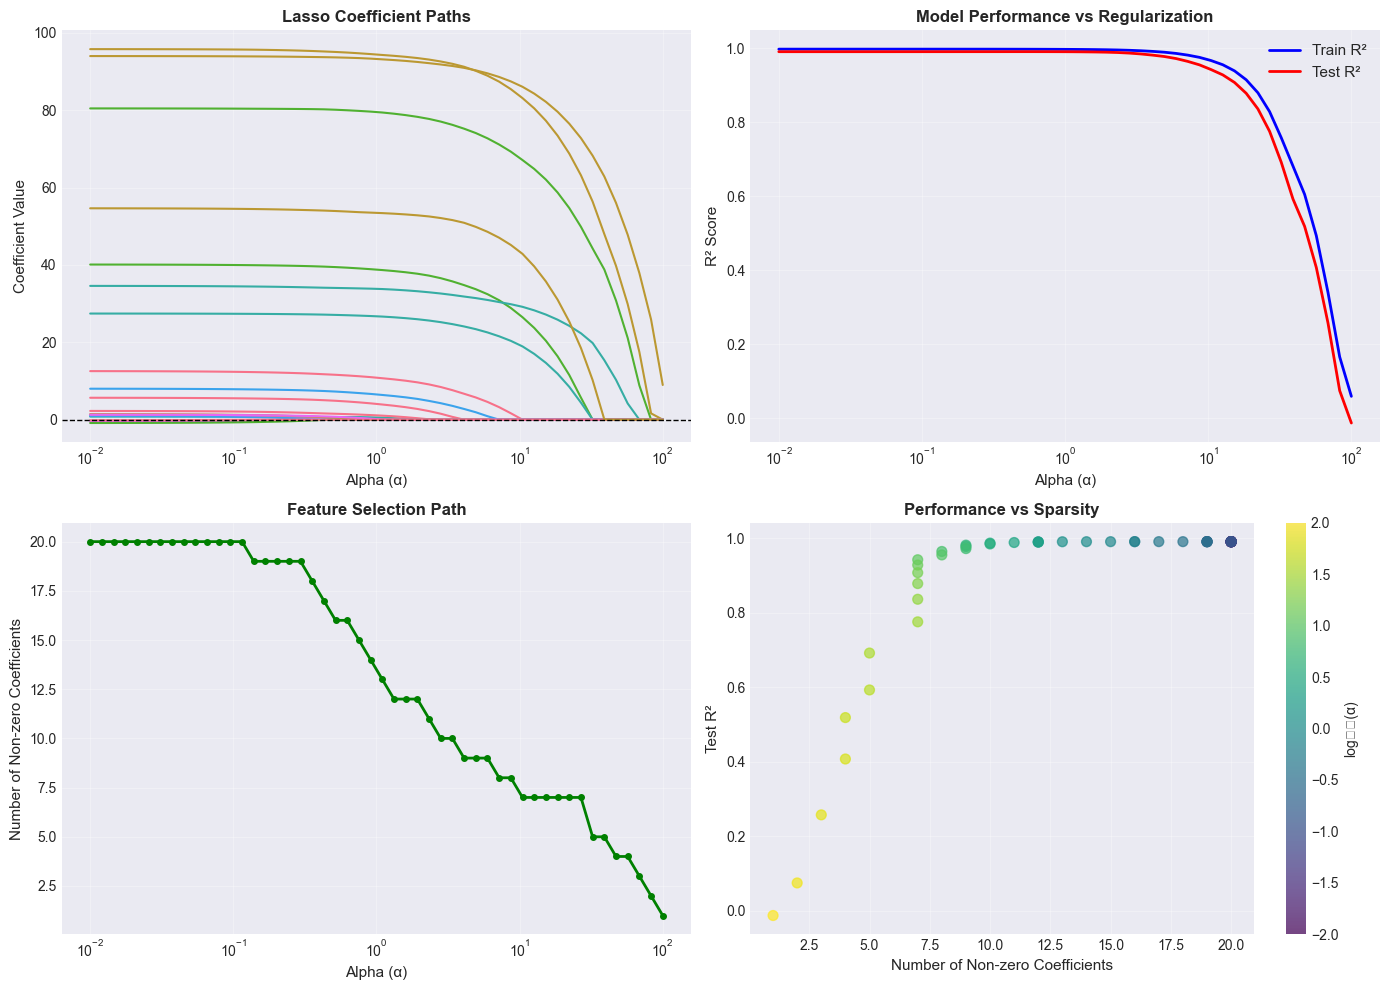

=== LASSO PATH ANALYSIS ===

Key observations:
• Coefficients drop to exactly zero (sparse solutions)
• Features eliminated one by one as α increases
• Sharp transitions when coefficients hit zero
• Trade-off between sparsity and accuracy


In [5]:
# Lasso coefficient paths
def visualize_lasso_paths():
    # Generate data
    X, y = make_regression(n_samples=100, n_features=20, 
                          n_informative=10, noise=10, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Try many alpha values
    alphas = np.logspace(-2, 2, 50)
    coefs = []
    train_scores = []
    test_scores = []
    n_nonzeros = []
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X_train, y_train)
        coefs.append(lasso.coef_)
        train_scores.append(lasso.score(X_train, y_train))
        test_scores.append(lasso.score(X_test, y_test))
        n_nonzeros.append(np.sum(np.abs(lasso.coef_) > 1e-5))
    
    coefs = np.array(coefs)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Coefficient paths
    axes[0, 0].plot(alphas, coefs)
    axes[0, 0].set_xscale('log')
    axes[0, 0].set_xlabel('Alpha (α)', fontsize=11)
    axes[0, 0].set_ylabel('Coefficient Value', fontsize=11)
    axes[0, 0].set_title('Lasso Coefficient Paths', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    # Performance vs alpha
    axes[0, 1].plot(alphas, train_scores, 'b-', linewidth=2, label='Train R²')
    axes[0, 1].plot(alphas, test_scores, 'r-', linewidth=2, label='Test R²')
    axes[0, 1].set_xscale('log')
    axes[0, 1].set_xlabel('Alpha (α)', fontsize=11)
    axes[0, 1].set_ylabel('R² Score', fontsize=11)
    axes[0, 1].set_title('Model Performance vs Regularization', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Number of selected features
    axes[1, 0].plot(alphas, n_nonzeros, 'g-', linewidth=2, marker='o', markersize=4)
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_xlabel('Alpha (α)', fontsize=11)
    axes[1, 0].set_ylabel('Number of Non-zero Coefficients', fontsize=11)
    axes[1, 0].set_title('Feature Selection Path', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Test performance vs sparsity
    axes[1, 1].scatter(n_nonzeros, test_scores, c=np.log10(alphas), 
                      cmap='viridis', s=50, alpha=0.7)
    axes[1, 1].set_xlabel('Number of Non-zero Coefficients', fontsize=11)
    axes[1, 1].set_ylabel('Test R²', fontsize=11)
    axes[1, 1].set_title('Performance vs Sparsity', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
    cbar.set_label('log₁₀(α)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("=== LASSO PATH ANALYSIS ===")
    print("\nKey observations:")
    print("• Coefficients drop to exactly zero (sparse solutions)")
    print("• Features eliminated one by one as α increases")
    print("• Sharp transitions when coefficients hit zero")
    print("• Trade-off between sparsity and accuracy")

visualize_lasso_paths()

---
## 4. Ridge vs Lasso: Direct Comparison

### Geometric Interpretation

**Ridge (L2)**:
- Constraint region: Circle ($w_1^2 + w_2^2 \leq t$)
- Solution rarely exactly zero
- Smooth at axes

**Lasso (L1)**:
- Constraint region: Diamond ($|w_1| + |w_2| \leq t$)
- Solution often exactly zero
- Sharp corners at axes

/var/folders/1k/26p0wvvn3pq_5gdg1nyk14340000gn/T/ipykernel_48319/1053646405.py:83: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1k/26p0wvvn3pq_5gdg1nyk14340000gn/T/ipykernel_48319/1053646405.py:83: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/savithavijayarangan/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


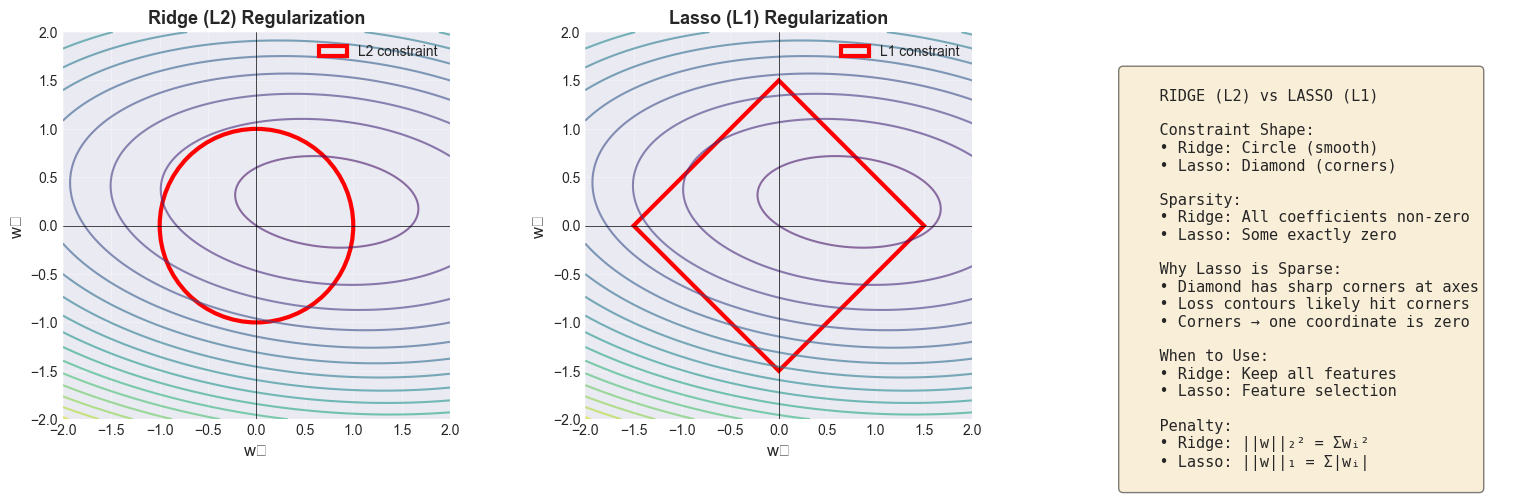

In [6]:
# Geometric visualization of L1 vs L2
def visualize_l1_l2_geometry():
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Create grid
    w1 = np.linspace(-2, 2, 400)
    w2 = np.linspace(-2, 2, 400)
    W1, W2 = np.meshgrid(w1, w2)
    
    # Simulated loss contours (ellipses)
    loss = 0.5 * W1**2 + 2 * W2**2 + 0.3 * W1 * W2 - 0.8 * W1 - 1.2 * W2
    
    # Ridge constraint (circle)
    t_ridge = 1.0
    ridge_constraint = W1**2 + W2**2
    
    # Lasso constraint (diamond)
    t_lasso = 1.5
    
    # Plot Ridge
    axes[0].contour(W1, W2, loss, levels=15, cmap='viridis', alpha=0.6)
    circle = plt.Circle((0, 0), np.sqrt(t_ridge), fill=False, 
                        edgecolor='red', linewidth=3, label='L2 constraint')
    axes[0].add_patch(circle)
    axes[0].set_xlabel('w₁', fontsize=12)
    axes[0].set_ylabel('w₂', fontsize=12)
    axes[0].set_title('Ridge (L2) Regularization', fontsize=13, fontweight='bold')
    axes[0].set_aspect('equal')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='black', linewidth=0.5)
    axes[0].axvline(x=0, color='black', linewidth=0.5)
    axes[0].legend(fontsize=10)
    axes[0].set_xlim(-2, 2)
    axes[0].set_ylim(-2, 2)
    
    # Plot Lasso
    axes[1].contour(W1, W2, loss, levels=15, cmap='viridis', alpha=0.6)
    # Diamond for Lasso
    diamond = plt.Polygon([[-t_lasso, 0], [0, t_lasso], [t_lasso, 0], [0, -t_lasso]], 
                          fill=False, edgecolor='red', linewidth=3, label='L1 constraint')
    axes[1].add_patch(diamond)
    axes[1].set_xlabel('w₁', fontsize=12)
    axes[1].set_ylabel('w₂', fontsize=12)
    axes[1].set_title('Lasso (L1) Regularization', fontsize=13, fontweight='bold')
    axes[1].set_aspect('equal')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='black', linewidth=0.5)
    axes[1].axvline(x=0, color='black', linewidth=0.5)
    axes[1].legend(fontsize=10)
    axes[1].set_xlim(-2, 2)
    axes[1].set_ylim(-2, 2)
    
    # Comparison text
    axes[2].axis('off')
    comparison_text = """
    RIDGE (L2) vs LASSO (L1)
    
    Constraint Shape:
    • Ridge: Circle (smooth)
    • Lasso: Diamond (corners)
    
    Sparsity:
    • Ridge: All coefficients non-zero
    • Lasso: Some exactly zero
    
    Why Lasso is Sparse:
    • Diamond has sharp corners at axes
    • Loss contours likely hit corners
    • Corners → one coordinate is zero
    
    When to Use:
    • Ridge: Keep all features
    • Lasso: Feature selection
    
    Penalty:
    • Ridge: ||w||₂² = Σwᵢ²
    • Lasso: ||w||₁ = Σ|wᵢ|
    """
    axes[2].text(0.1, 0.9, comparison_text, transform=axes[2].transAxes,
                fontsize=11, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

visualize_l1_l2_geometry()

### Side-by-Side Comparison

=== RIDGE VS LASSO COMPARISON ===

Data: 100 samples, 30 features (10 informative)

Model              | Train R² | Test R² | Non-zero | Max |coef|
----------------------------------------------------------------------
Linear Regression  |   0.9956 |  0.9630 |       30 |      98.81
Ridge (α=1.0)      |   0.9954 |  0.9615 |       30 |      97.23
Lasso (α=1.0)      |   0.9950 |  0.9691 |       23 |      98.30


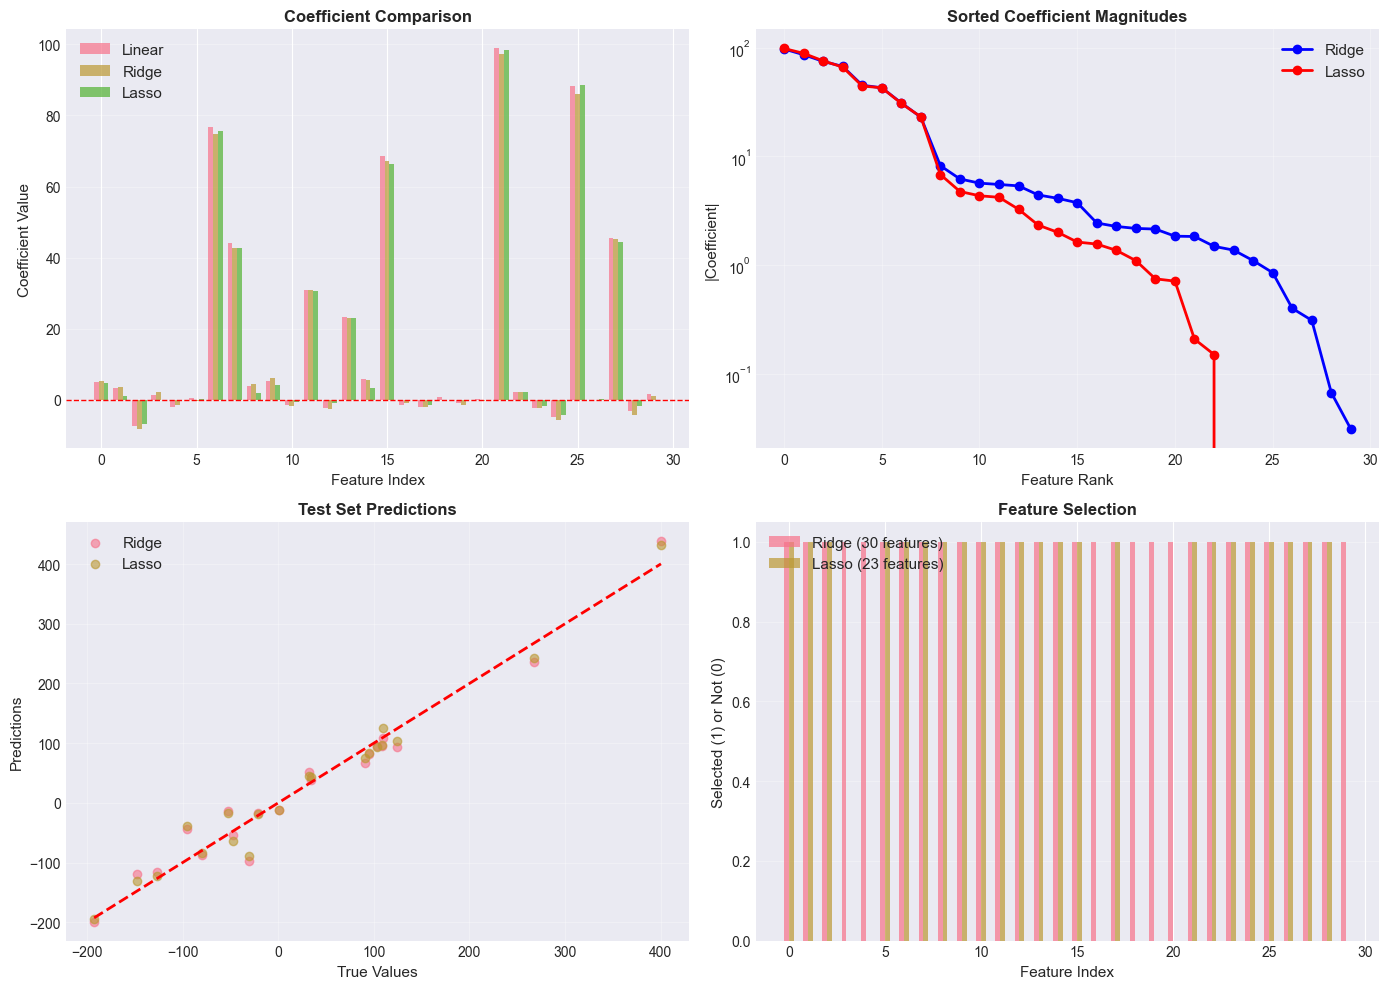


=== KEY DIFFERENCES ===

Ridge:
  ✓ Keeps all features
  ✓ Shrinks all coefficients smoothly
  ✓ Good when all features are relevant

Lasso:
  ✓ Eliminates irrelevant features
  ✓ Sparse solution (many zeros)
  ✓ Good for feature selection
  ✓ More interpretable (fewer features)


In [7]:
# Direct comparison on same dataset
def compare_ridge_lasso():
    # Generate data with mix of important and unimportant features
    np.random.seed(42)
    n_samples = 100
    n_features = 30
    n_informative = 10
    
    X, y = make_regression(n_samples=n_samples, n_features=n_features,
                          n_informative=n_informative, noise=20, random_state=42)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Fit models with same alpha
    alpha = 1.0
    
    ridge = Ridge(alpha=alpha)
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lr = LinearRegression()
    
    ridge.fit(X_train, y_train)
    lasso.fit(X_train, y_train)
    lr.fit(X_train, y_train)
    
    # Results
    models = {
        'Linear Regression': lr,
        'Ridge (α=1.0)': ridge,
        'Lasso (α=1.0)': lasso
    }
    
    print("=== RIDGE VS LASSO COMPARISON ===")
    print(f"\nData: {n_samples} samples, {n_features} features ({n_informative} informative)")
    print("\nModel              | Train R² | Test R² | Non-zero | Max |coef|")
    print("-" * 70)
    
    for name, model in models.items():
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        n_nonzero = np.sum(np.abs(model.coef_) > 1e-5)
        max_coef = np.max(np.abs(model.coef_))
        
        print(f"{name:18s} | {train_score:8.4f} | {test_score:7.4f} | "
              f"{n_nonzero:8d} | {max_coef:10.2f}")
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Coefficient comparison
    x_pos = np.arange(n_features)
    width = 0.25
    
    axes[0, 0].bar(x_pos - width, lr.coef_, width, label='Linear', alpha=0.7)
    axes[0, 0].bar(x_pos, ridge.coef_, width, label='Ridge', alpha=0.7)
    axes[0, 0].bar(x_pos + width, lasso.coef_, width, label='Lasso', alpha=0.7)
    axes[0, 0].set_xlabel('Feature Index', fontsize=11)
    axes[0, 0].set_ylabel('Coefficient Value', fontsize=11)
    axes[0, 0].set_title('Coefficient Comparison', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
    
    # Coefficient magnitudes (sorted)
    ridge_sorted = np.sort(np.abs(ridge.coef_))[::-1]
    lasso_sorted = np.sort(np.abs(lasso.coef_))[::-1]
    
    axes[0, 1].plot(ridge_sorted, 'bo-', label='Ridge', linewidth=2, markersize=6)
    axes[0, 1].plot(lasso_sorted, 'ro-', label='Lasso', linewidth=2, markersize=6)
    axes[0, 1].set_xlabel('Feature Rank', fontsize=11)
    axes[0, 1].set_ylabel('|Coefficient|', fontsize=11)
    axes[0, 1].set_title('Sorted Coefficient Magnitudes', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_yscale('log')
    
    # Predictions comparison
    y_pred_ridge = ridge.predict(X_test)
    y_pred_lasso = lasso.predict(X_test)
    
    axes[1, 0].scatter(y_test, y_pred_ridge, alpha=0.6, label='Ridge')
    axes[1, 0].scatter(y_test, y_pred_lasso, alpha=0.6, label='Lasso')
    axes[1, 0].plot([y_test.min(), y_test.max()], 
                    [y_test.min(), y_test.max()], 'r--', linewidth=2)
    axes[1, 0].set_xlabel('True Values', fontsize=11)
    axes[1, 0].set_ylabel('Predictions', fontsize=11)
    axes[1, 0].set_title('Test Set Predictions', fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Feature selection visualization
    ridge_nonzero = np.abs(ridge.coef_) > 1e-5
    lasso_nonzero = np.abs(lasso.coef_) > 1e-5
    
    axes[1, 1].bar(x_pos - width/2, ridge_nonzero, width, 
                  label=f'Ridge ({ridge_nonzero.sum()} features)', alpha=0.7)
    axes[1, 1].bar(x_pos + width/2, lasso_nonzero, width, 
                  label=f'Lasso ({lasso_nonzero.sum()} features)', alpha=0.7)
    axes[1, 1].set_xlabel('Feature Index', fontsize=11)
    axes[1, 1].set_ylabel('Selected (1) or Not (0)', fontsize=11)
    axes[1, 1].set_title('Feature Selection', fontsize=12, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== KEY DIFFERENCES ===")
    print("\nRidge:")
    print("  ✓ Keeps all features")
    print("  ✓ Shrinks all coefficients smoothly")
    print("  ✓ Good when all features are relevant")
    
    print("\nLasso:")
    print("  ✓ Eliminates irrelevant features")
    print("  ✓ Sparse solution (many zeros)")
    print("  ✓ Good for feature selection")
    print("  ✓ More interpretable (fewer features)")

compare_ridge_lasso()

---
## 5. Elastic Net: Best of Both Worlds

### Combining L1 and L2

**Elastic Net** uses both penalties:

$$L_{ElasticNet}(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \mathbf{w}^T\mathbf{x}_i)^2 + \alpha\rho||\mathbf{w}||_1 + \frac{\alpha(1-\rho)}{2}||\mathbf{w}||^2$$

Where:
- $\alpha$ : overall regularization strength
- $\rho \in [0, 1]$ : L1 ratio
  - $\rho = 0$ : Pure Ridge
  - $\rho = 1$ : Pure Lasso
  - $0 < \rho < 1$ : Combination

### Advantages:
1. **Feature selection** like Lasso
2. **Handles correlated features** like Ridge
3. **Stable** with more features selected than Lasso
4. **Flexible** through $\rho$ parameter

=== ELASTIC NET ===

L1 Ratio | Model                | Train R² | Test R²  | Non-zero
----------------------------------------------------------------------
    0.00 | Ridge                |   0.9930 |   0.9862 |       30
    0.25 | ElasticNet (ρ=0.25)  |   0.7996 |   0.7492 |       28
    0.50 | ElasticNet (ρ=0.5)   |   0.8627 |   0.8228 |       29
    0.75 | ElasticNet (ρ=0.75)  |   0.9346 |   0.9099 |       30
    1.00 | Lasso                |   0.9923 |   0.9876 |       24


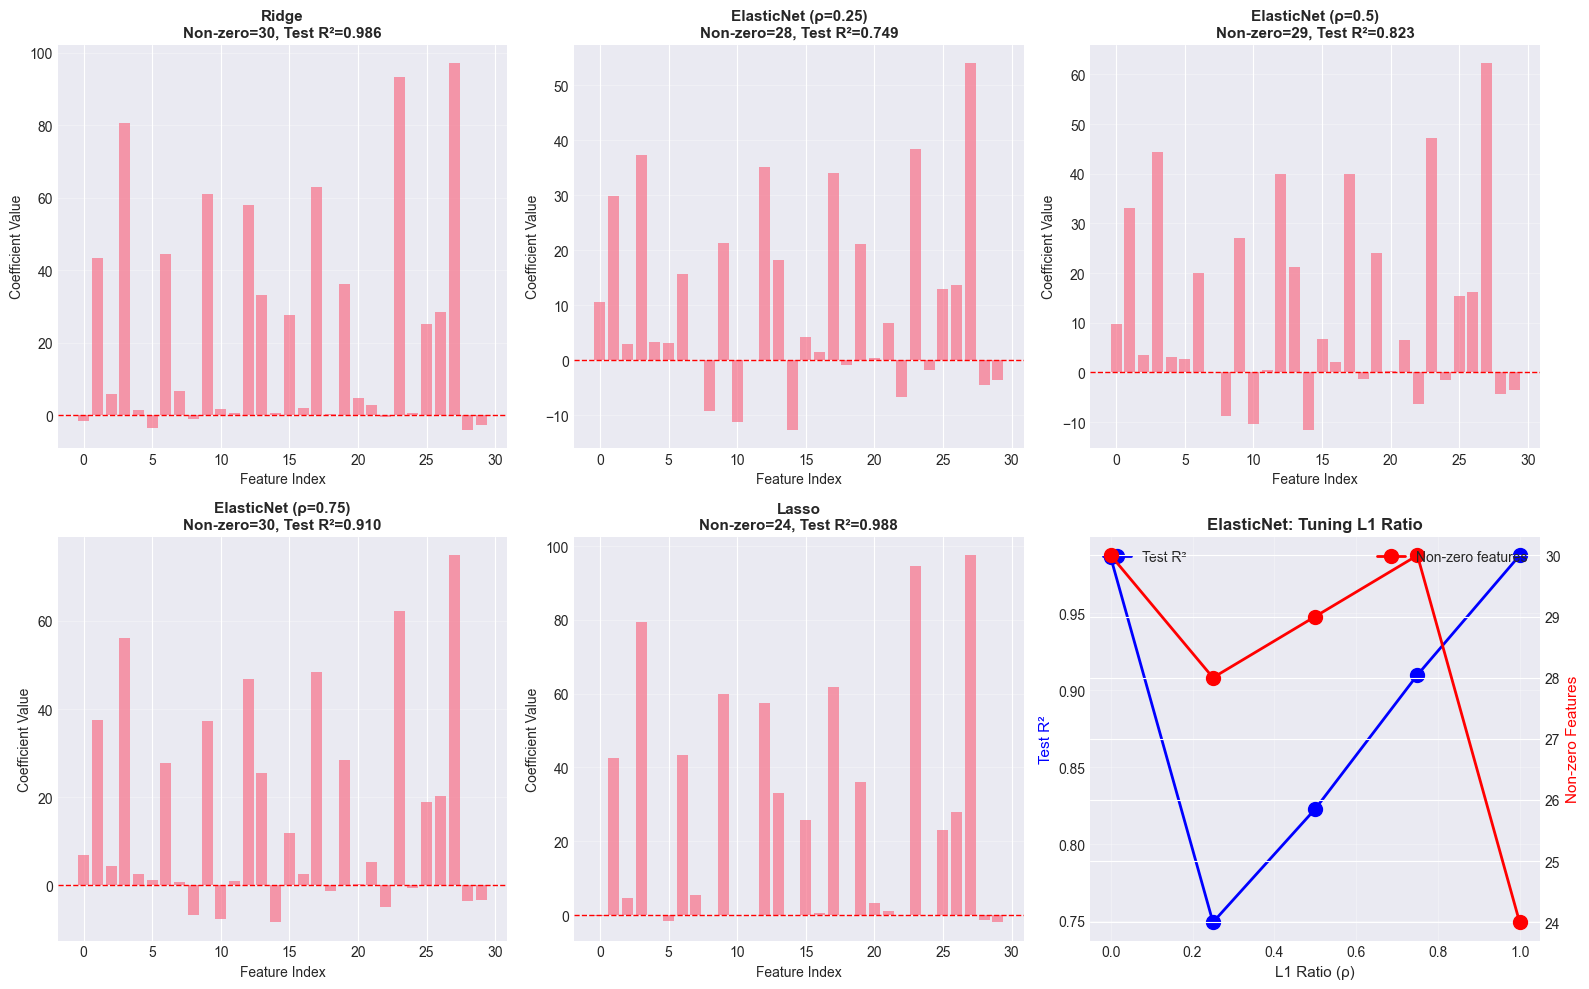


=== ELASTIC NET BENEFITS ===

• ρ=0 (Ridge): No sparsity, all features kept
• ρ=1 (Lasso): Maximum sparsity, aggressive selection
• 0<ρ<1: Balance between Ridge and Lasso
• Use ElasticNet when:
  - Features are correlated (Lasso arbitrary choice)
  - Want some sparsity but not too aggressive
  - Lasso is unstable


In [8]:
# Demonstrate Elastic Net
print("=== ELASTIC NET ===")

# Generate data
X, y = make_regression(n_samples=100, n_features=30,
                      n_informative=15, noise=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Compare different l1_ratio values
l1_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
alpha = 1.0

results = []

for l1_ratio in l1_ratios:
    if l1_ratio == 0.0:
        model = Ridge(alpha=alpha)
        name = 'Ridge'
    elif l1_ratio == 1.0:
        model = Lasso(alpha=alpha, max_iter=10000)
        name = 'Lasso'
    else:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        name = f'ElasticNet (ρ={l1_ratio})'
    
    model.fit(X_train, y_train)
    
    results.append({
        'L1 Ratio (ρ)': l1_ratio,
        'Model': name,
        'Train R²': model.score(X_train, y_train),
        'Test R²': model.score(X_test, y_test),
        'Non-zero': np.sum(np.abs(model.coef_) > 1e-5),
        'Coef': model.coef_.copy()
    })

# Display results
print("\nL1 Ratio | Model                | Train R² | Test R²  | Non-zero")
print("-" * 70)
for r in results:
    print(f"{r['L1 Ratio (ρ)']:8.2f} | {r['Model']:20s} | {r['Train R²']:8.4f} | "
          f"{r['Test R²']:8.4f} | {r['Non-zero']:8d}")

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for ax, result in zip(axes[:-1], results):
    ax.bar(range(len(result['Coef'])), result['Coef'], alpha=0.7)
    ax.set_xlabel('Feature Index', fontsize=10)
    ax.set_ylabel('Coefficient Value', fontsize=10)
    ax.set_title(f"{result['Model']}\nNon-zero={result['Non-zero']}, "
                f"Test R²={result['Test R²']:.3f}",
                fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Summary plot
axes[-1].plot([r['L1 Ratio (ρ)'] for r in results],
             [r['Test R²'] for r in results],
             'bo-', linewidth=2, markersize=10, label='Test R²')
ax2 = axes[-1].twinx()
ax2.plot([r['L1 Ratio (ρ)'] for r in results],
        [r['Non-zero'] for r in results],
        'ro-', linewidth=2, markersize=10, label='Non-zero features')
axes[-1].set_xlabel('L1 Ratio (ρ)', fontsize=11)
axes[-1].set_ylabel('Test R²', fontsize=11, color='blue')
ax2.set_ylabel('Non-zero Features', fontsize=11, color='red')
axes[-1].set_title('ElasticNet: Tuning L1 Ratio', fontsize=12, fontweight='bold')
axes[-1].legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
axes[-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== ELASTIC NET BENEFITS ===")
print("\n• ρ=0 (Ridge): No sparsity, all features kept")
print("• ρ=1 (Lasso): Maximum sparsity, aggressive selection")
print("• 0<ρ<1: Balance between Ridge and Lasso")
print("• Use ElasticNet when:")
print("  - Features are correlated (Lasso arbitrary choice)")
print("  - Want some sparsity but not too aggressive")
print("  - Lasso is unstable")

---
## 6. Selecting Regularization Parameters

### Cross-Validation Approach

The most reliable way to select α (and ρ for ElasticNet):
1. Define grid of parameter values
2. Use k-fold cross-validation
3. Select parameters with best CV score
4. Refit on full training set
5. Evaluate on test set (only once!)

=== HYPERPARAMETER TUNING WITH CROSS-VALIDATION ===

Ridge:
  Best alpha: 0.0655
  Train R²: 0.9979
  Test R²: 0.9970
  Non-zero features: 40

Lasso:
  Best alpha: 0.4942
  Train R²: 0.9978
  Test R²: 0.9965
  Non-zero features: 37

ElasticNet:
  Best alpha: 0.4942
  Best l1_ratio: 1.0000
  Train R²: 0.9978
  Test R²: 0.9965
  Non-zero features: 37


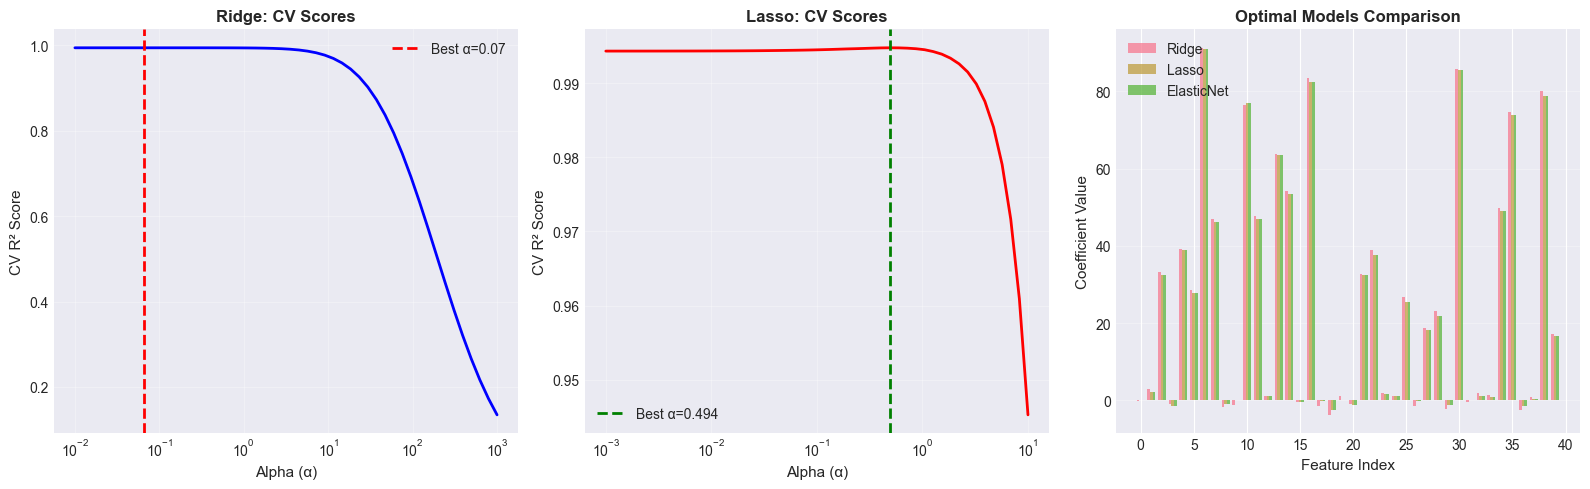


✓ Use CV models (RidgeCV, LassoCV, ElasticNetCV) for automatic tuning!


In [9]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# Generate data
X, y = make_regression(n_samples=150, n_features=40,
                      n_informative=20, noise=15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (important!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== HYPERPARAMETER TUNING WITH CROSS-VALIDATION ===")

# Ridge with CV
alphas_ridge = np.logspace(-2, 3, 50)
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print(f"\nRidge:")
print(f"  Best alpha: {ridge_cv.alpha_:.4f}")
print(f"  Train R²: {ridge_cv.score(X_train_scaled, y_train):.4f}")
print(f"  Test R²: {ridge_cv.score(X_test_scaled, y_test):.4f}")
print(f"  Non-zero features: {np.sum(np.abs(ridge_cv.coef_) > 1e-5)}")

# Lasso with CV
alphas_lasso = np.logspace(-3, 1, 50)
lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

print(f"\nLasso:")
print(f"  Best alpha: {lasso_cv.alpha_:.4f}")
print(f"  Train R²: {lasso_cv.score(X_train_scaled, y_train):.4f}")
print(f"  Test R²: {lasso_cv.score(X_test_scaled, y_test):.4f}")
print(f"  Non-zero features: {np.sum(np.abs(lasso_cv.coef_) > 1e-5)}")

# ElasticNet with CV
elastic_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                         alphas=alphas_lasso, cv=5, max_iter=10000)
elastic_cv.fit(X_train_scaled, y_train)

print(f"\nElasticNet:")
print(f"  Best alpha: {elastic_cv.alpha_:.4f}")
print(f"  Best l1_ratio: {elastic_cv.l1_ratio_:.4f}")
print(f"  Train R²: {elastic_cv.score(X_train_scaled, y_train):.4f}")
print(f"  Test R²: {elastic_cv.score(X_test_scaled, y_test):.4f}")
print(f"  Non-zero features: {np.sum(np.abs(elastic_cv.coef_) > 1e-5)}")

# Visualize CV results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Ridge CV scores
ridge_scores = []
for alpha in alphas_ridge:
    scores = cross_val_score(Ridge(alpha=alpha), X_train_scaled, y_train, cv=5)
    ridge_scores.append(scores.mean())

axes[0].plot(alphas_ridge, ridge_scores, 'b-', linewidth=2)
axes[0].axvline(x=ridge_cv.alpha_, color='red', linestyle='--', 
               linewidth=2, label=f'Best α={ridge_cv.alpha_:.2f}')
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha (α)', fontsize=11)
axes[0].set_ylabel('CV R² Score', fontsize=11)
axes[0].set_title('Ridge: CV Scores', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Lasso CV scores
lasso_scores = []
for alpha in alphas_lasso:
    scores = cross_val_score(Lasso(alpha=alpha, max_iter=10000), 
                            X_train_scaled, y_train, cv=5)
    lasso_scores.append(scores.mean())

axes[1].plot(alphas_lasso, lasso_scores, 'r-', linewidth=2)
axes[1].axvline(x=lasso_cv.alpha_, color='green', linestyle='--',
               linewidth=2, label=f'Best α={lasso_cv.alpha_:.3f}')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha (α)', fontsize=11)
axes[1].set_ylabel('CV R² Score', fontsize=11)
axes[1].set_title('Lasso: CV Scores', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Coefficient comparison
x_pos = np.arange(len(ridge_cv.coef_))
width = 0.25
axes[2].bar(x_pos - width, ridge_cv.coef_, width, label='Ridge', alpha=0.7)
axes[2].bar(x_pos, lasso_cv.coef_, width, label='Lasso', alpha=0.7)
axes[2].bar(x_pos + width, elastic_cv.coef_, width, label='ElasticNet', alpha=0.7)
axes[2].set_xlabel('Feature Index', fontsize=11)
axes[2].set_ylabel('Coefficient Value', fontsize=11)
axes[2].set_title('Optimal Models Comparison', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Use CV models (RidgeCV, LassoCV, ElasticNetCV) for automatic tuning!")

---
## 7. Real-World Application: Diabetes Dataset

=== DIABETES DATASET ===

Samples: 442
Features: 10

Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Target: Disease progression after one year

=== MODEL COMPARISON ===
            Model  Train R²  Test R²  Train RMSE  Test RMSE  Non-zero    Alpha  L1 Ratio
Linear Regression  0.527919 0.452603   53.558843  53.853446        10      NaN       NaN
       Ridge (CV)  0.527483 0.454459   53.583590  53.762043        10 1.325711       NaN
       Lasso (CV)  0.519470 0.471195   54.036004  52.930970         8 1.526418       NaN
  ElasticNet (CV)  0.521705 0.460266   53.910221  53.475135        10 0.109854       0.1


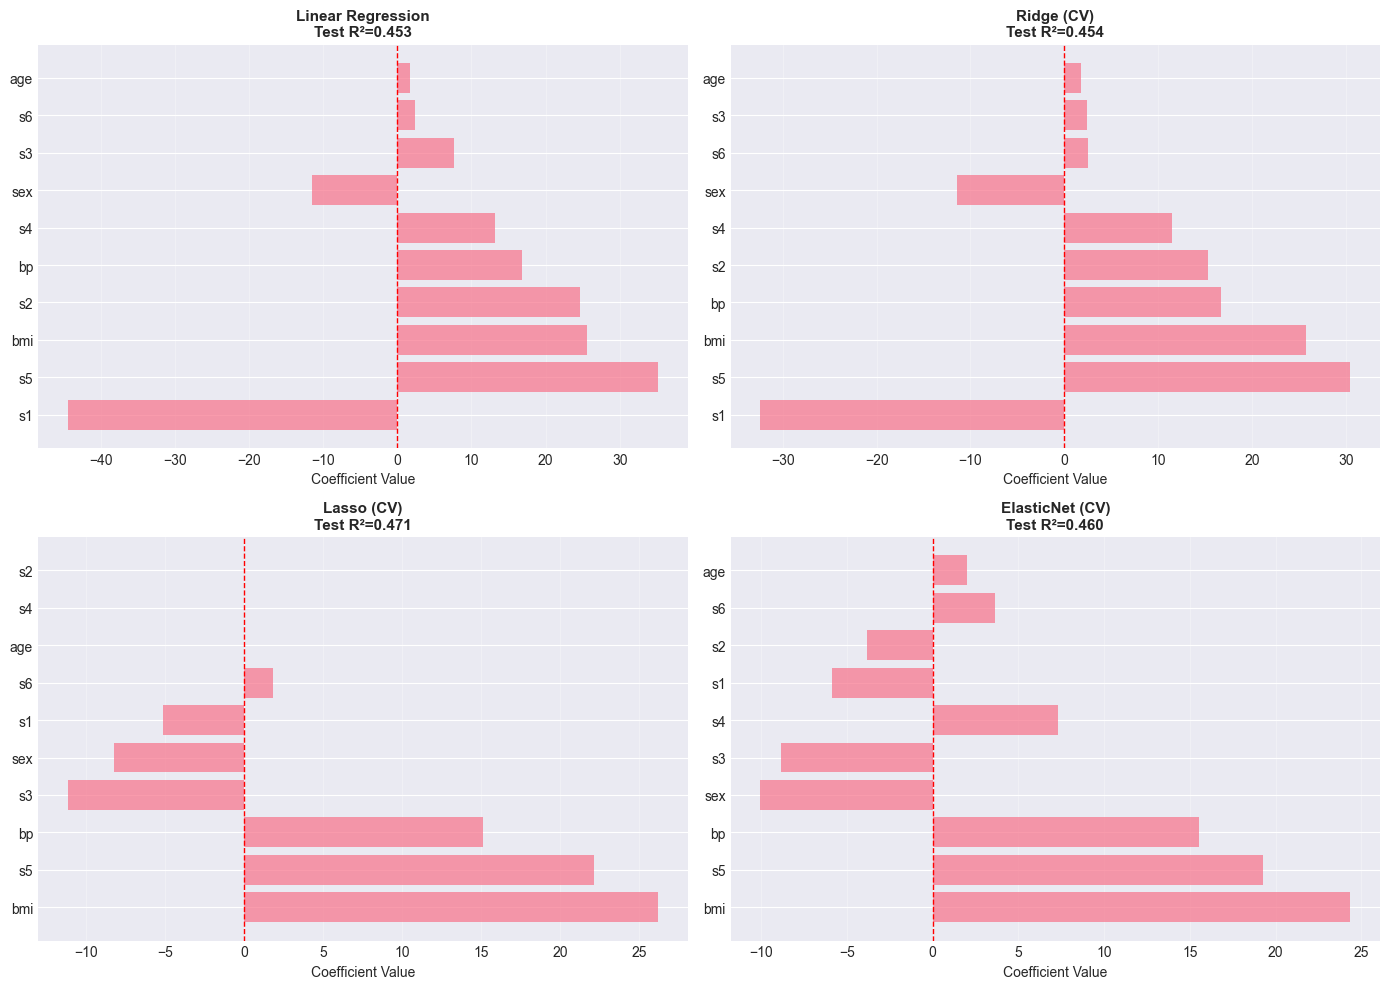


=== BEST MODEL ===
Model: Lasso (CV)
Test R²: 0.4712

=== INSIGHTS ===
• Regularization improves test performance
• Lasso selects most important features
• ElasticNet balances performance and sparsity
• All models identify similar important features


In [10]:
# Load diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

print("=== DIABETES DATASET ===")
print(f"\nSamples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"\nFeature names: {diabetes.feature_names}")
print(f"\nTarget: Disease progression after one year")

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train all models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (CV)': RidgeCV(alphas=np.logspace(-2, 2, 50)),
    'Lasso (CV)': LassoCV(alphas=np.logspace(-3, 1, 50), max_iter=10000),
    'ElasticNet (CV)': ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99],
                                    alphas=np.logspace(-3, 1, 50), max_iter=10000)
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    result = {
        'Model': name,
        'Train R²': r2_score(y_train, y_pred_train),
        'Test R²': r2_score(y_test, y_pred_test),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Non-zero': np.sum(np.abs(model.coef_) > 1e-5)
    }
    
    if hasattr(model, 'alpha_'):
        result['Alpha'] = model.alpha_
    if hasattr(model, 'l1_ratio_'):
        result['L1 Ratio'] = model.l1_ratio_
    
    results.append(result)

# Display results
results_df = pd.DataFrame(results)
print("\n=== MODEL COMPARISON ===")
print(results_df.to_string(index=False))

# Feature importance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    # Get coefficients
    coef = model.coef_
    
    # Sort by absolute value
    sorted_idx = np.argsort(np.abs(coef))[::-1]
    
    # Plot
    ax.barh(range(len(coef)), coef[sorted_idx], alpha=0.7)
    ax.set_yticks(range(len(coef)))
    ax.set_yticklabels([diabetes.feature_names[i] for i in sorted_idx])
    ax.set_xlabel('Coefficient Value', fontsize=10)
    ax.set_title(f'{name}\nTest R²={r2_score(y_test, model.predict(X_test_scaled)):.3f}',
                fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# Best model analysis
best_idx = results_df['Test R²'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_test_r2 = results_df.loc[best_idx, 'Test R²']

print(f"\n=== BEST MODEL ===")
print(f"Model: {best_model_name}")
print(f"Test R²: {best_test_r2:.4f}")

print("\n=== INSIGHTS ===")
print("• Regularization improves test performance")
print("• Lasso selects most important features")
print("• ElasticNet balances performance and sparsity")
print("• All models identify similar important features")

---
## 8. Summary and Best Practices

In [11]:
print("="*70)
print("RIDGE vs LASSO vs ELASTIC NET: COMPLETE GUIDE")
print("="*70)

print("\n📊 COMPARISON TABLE")
print("-" * 70)
print(f"{'Property':<25} {'Ridge (L2)':<20} {'Lasso (L1)':<20}")
print("-" * 70)
print(f"{'Penalty':<25} {'Σwᵢ²':<20} {'Σ|wᵢ|':<20}")
print(f"{'Sparsity':<25} {'No':<20} {'Yes':<20}")
print(f"{'Feature Selection':<25} {'No':<20} {'Yes':<20}")
print(f"{'Closed-form Solution':<25} {'Yes':<20} {'No':<20}")
print(f"{'Handles Correlation':<25} {'Yes':<20} {'Arbitrary choice':<20}")
print(f"{'Computational Cost':<25} {'Low':<20} {'Medium':<20}")
print("-" * 70)

print("\n🎯 WHEN TO USE EACH")
print("-" * 70)

print("\n✅ USE RIDGE WHEN:")
print("   • All features might be relevant")
print("   • Features are correlated")
print("   • Want to keep all features")
print("   • Need fast training")
print("   • Multicollinearity is an issue")

print("\n✅ USE LASSO WHEN:")
print("   • Feature selection is needed")
print("   • Many irrelevant features")
print("   • Want interpretable model (fewer features)")
print("   • Sparse solution is desired")
print("   • Features are not highly correlated")

print("\n✅ USE ELASTIC NET WHEN:")
print("   • Features are correlated (Lasso unstable)")
print("   • Want some sparsity")
print("   • Need balance between Ridge and Lasso")
print("   • Lasso selects too few features")

print("\n⚙️ BEST PRACTICES")
print("-" * 70)
print("\n1. ALWAYS SCALE FEATURES")
print("   • Use StandardScaler or MinMaxScaler")
print("   • Critical for regularization to work properly")

print("\n2. USE CROSS-VALIDATION")
print("   • RidgeCV, LassoCV, ElasticNetCV")
print("   • Let the model find optimal α automatically")

print("\n3. TUNE HYPERPARAMETERS")
print("   • Try wide range of α values (logspace)")
print("   • For ElasticNet, also tune l1_ratio")

print("\n4. INTERPRET COEFFICIENTS")
print("   • Large |coefficient| = important feature")
print("   • Zero coefficient (Lasso) = feature eliminated")
print("   • Compare feature importance across models")

print("\n5. VALIDATE PROPERLY")
print("   • Train/Validation/Test split")
print("   • Never tune on test set")
print("   • Use cross-validation for model selection")

print("\n📝 KEY FORMULAS")
print("-" * 70)
print("\nRidge: L = MSE + α Σwᵢ²")
print("       w* = (XᵀX + αI)⁻¹Xᵀy")

print("\nLasso: L = MSE + α Σ|wᵢ|")
print("       (No closed form - use coordinate descent)")

print("\nElasticNet: L = MSE + αρ Σ|wᵢ| + α(1-ρ)/2 Σwᵢ²")
print("            (ρ ∈ [0,1] controls L1/L2 mix)")

print("\n" + "="*70)

RIDGE vs LASSO vs ELASTIC NET: COMPLETE GUIDE

📊 COMPARISON TABLE
----------------------------------------------------------------------
Property                  Ridge (L2)           Lasso (L1)          
----------------------------------------------------------------------
Penalty                   Σwᵢ²                 Σ|wᵢ|               
Sparsity                  No                   Yes                 
Feature Selection         No                   Yes                 
Closed-form Solution      Yes                  No                  
Handles Correlation       Yes                  Arbitrary choice    
Computational Cost        Low                  Medium              
----------------------------------------------------------------------

🎯 WHEN TO USE EACH
----------------------------------------------------------------------

✅ USE RIDGE WHEN:
   • All features might be relevant
   • Features are correlated
   • Want to keep all features
   • Need fast training
   • Multicolli

---
## 9. Practice Exercises

### Exercise 1: Implement Ridge from Scratch
Complete the Ridge regression implementation with gradient descent

In [12]:
# Exercise 1 - Your code here
# Implement Ridge using gradient descent instead of closed form


### Exercise 2: Compare on High-Dimensional Data
Generate data with n_features > n_samples and compare all methods

In [13]:
# Exercise 2 - Your code here


### Exercise 3: Feature Selection with Lasso
Use Lasso to select the top k most important features

In [14]:
# Exercise 3 - Your code here


---
## 10. Key Takeaways

### Core Concepts:
1. ✅ **Regularization** prevents overfitting by penalizing large weights
2. ✅ **Ridge (L2)** shrinks all coefficients smoothly
3. ✅ **Lasso (L1)** can force coefficients to exactly zero
4. ✅ **ElasticNet** combines benefits of both
5. ✅ **Cross-validation** essential for selecting α

### When to Use:
- **Many features** → Use regularization
- **Need all features** → Ridge
- **Need feature selection** → Lasso
- **Correlated features** → Ridge or ElasticNet
- **Uncertain** → Try ElasticNet with CV

### Mathematical Foundation:
**Ridge**: $L = MSE + \alpha||\mathbf{w}||^2$

**Lasso**: $L = MSE + \alpha||\mathbf{w}||_1$

**ElasticNet**: $L = MSE + \alpha\rho||\mathbf{w}||_1 + \frac{\alpha(1-\rho)}{2}||\mathbf{w}||^2$

---

**Congratulations! You understand regularization! 🎉**

**You can now build robust models that generalize well!**